In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
! unzip /content/drive/MyDrive/LeapGestRecog.zip

Streaming output truncated to the last 5000 lines.
  inflating: LeapGestRecog/leapGestRecog/07/06_index/frame_07_06_0027.png  
  inflating: LeapGestRecog/leapGestRecog/07/06_index/frame_07_06_0028.png  
  inflating: LeapGestRecog/leapGestRecog/07/06_index/frame_07_06_0029.png  
  inflating: LeapGestRecog/leapGestRecog/07/06_index/frame_07_06_0030.png  
  inflating: LeapGestRecog/leapGestRecog/07/06_index/frame_07_06_0031.png  
  inflating: LeapGestRecog/leapGestRecog/07/06_index/frame_07_06_0032.png  
  inflating: LeapGestRecog/leapGestRecog/07/06_index/frame_07_06_0033.png  
  inflating: LeapGestRecog/leapGestRecog/07/06_index/frame_07_06_0034.png  
  inflating: LeapGestRecog/leapGestRecog/07/06_index/frame_07_06_0035.png  
  inflating: LeapGestRecog/leapGestRecog/07/06_index/frame_07_06_0036.png  
  inflating: LeapGestRecog/leapGestRecog/07/06_index/frame_07_06_0037.png  
  inflating: LeapGestRecog/leapGestRecog/07/06_index/frame_07_06_0038.png  
  inflating: LeapGestRecog/leapGestRe

#Import Necessary Libraries



In [16]:
import os
import numpy as np
import cv2
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras.utils import to_categorical

In [17]:
img_size = (64, 64)
num_classes = 10
data_dir = '/content/LeapGestRecog/leapGestRecog'

#Load Images

In [18]:
images = []
labels = []

# Load images and labels
for main_folder in os.listdir(data_dir):
    main_folder_path = os.path.join(data_dir, main_folder)
    if os.path.isdir(main_folder_path):
        for gesture in os.listdir(main_folder_path):
            gesture_path = os.path.join(main_folder_path, gesture)
            if os.path.isdir(gesture_path):
                for img_file in os.listdir(gesture_path):
                    img_path = os.path.join(gesture_path, img_file)
                    img = cv2.imread(img_path)
                    if img is not None:
                        img = cv2.resize(img, img_size)
                        images.append(img)
                        labels.append(gesture)
                    else:
                        print(f"Warning: Image at path {img_path} could not be loaded.")

# Convert lists to numpy arrays
images = np.array(images)
labels = np.array(labels)

In [19]:
if len(images) == 0 or len(labels) == 0:
    raise ValueError("No images or labels were loaded. Please check the dataset path and contents.")


# Normalize the images

In [20]:
images = images.astype('float32') / 255.0

# Encode labels to numerical values

In [21]:
label_names = sorted(set(labels))
label_map = {label: idx for idx, label in enumerate(label_names)}
encoded_labels = np.array([label_map[label] for label in labels])

# One-hot encode the labels

In [22]:
encoded_labels = to_categorical(encoded_labels, num_classes)

# Split Data

In [23]:
X_train, X_test, y_train, y_test = train_test_split(images, encoded_labels, test_size=0.2, random_state=42)


In [24]:
print(f"Training data shape: {X_train.shape}, {y_train.shape}")
print(f"Testing data shape: {X_test.shape}, {y_test.shape}")

Training data shape: (16000, 64, 64, 3), (16000, 10)
Testing data shape: (4000, 64, 64, 3), (4000, 10)


# Display class names and their corresponding labels

In [25]:
print("Class labels and their corresponding indices:")
for label, idx in label_map.items():
    print(f"{idx}: {label}")

Class labels and their corresponding indices:
0: 01_palm
1: 02_l
2: 03_fist
3: 04_fist_moved
4: 05_thumb
5: 06_index
6: 07_ok
7: 08_palm_moved
8: 09_c
9: 10_down


# Visualize the class distribution

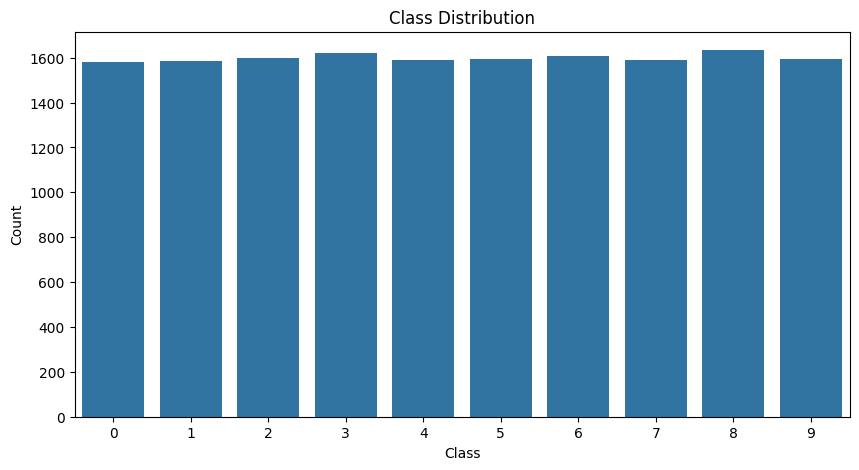

In [26]:
plt.figure(figsize=(10, 5))
sns.countplot(x=np.argmax(y_train, axis=1))
plt.title("Class Distribution")
plt.xlabel("Class")
plt.ylabel("Count")
plt.show()

# Display some sample images from each class

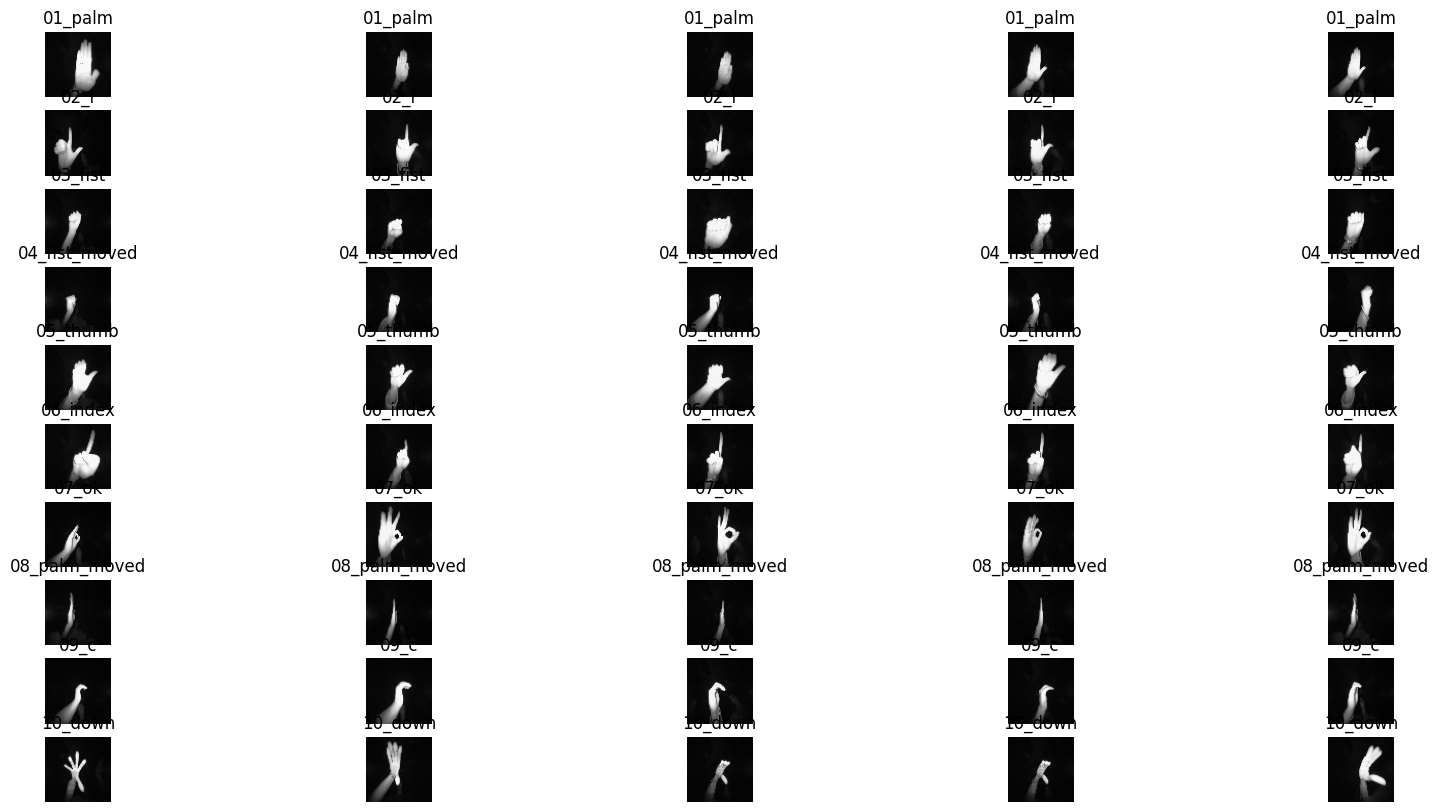

In [27]:
def display_sample_images_from_each_class(images, labels, label_names, label_map, num_samples=5):
    plt.figure(figsize=(20, 10))
    for label, idx in label_map.items():
        label_indices = np.where(np.argmax(labels, axis=1) == idx)[0]
        for i in range(num_samples):
            plt.subplot(num_classes, num_samples, idx*num_samples + i + 1)
            img_index = label_indices[i]
            plt.imshow(images[img_index])
            plt.title(f"{label}")
            plt.axis('off')
    plt.show()

display_sample_images_from_each_class(X_train, y_train, label_names, label_map)


# Data Augmentation

In [39]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
datagen = ImageDataGenerator(
    rotation_range=10,
    width_shift_range=0.1,
    height_shift_range=0.1,
    shear_range=0.1,
    zoom_range=0.1,
    horizontal_flip=True,
    fill_mode='nearest'
)

# Create the CNN model

In [40]:
def create_cnn_model(input_shape, num_classes):
    model = Sequential([
        Conv2D(32, (3, 3), activation='relu', input_shape=input_shape),
        MaxPooling2D((2, 2)),
        Conv2D(64, (3, 3), activation='relu'),
        MaxPooling2D((2, 2)),
        Conv2D(128, (3, 3), activation='relu'),
        MaxPooling2D((2, 2)),
        Flatten(),
        Dense(128, activation='relu'),
        Dropout(0.5),
        Dense(num_classes, activation='softmax')
    ])

    model.compile(optimizer='adam',
                  loss='categorical_crossentropy',
                  metrics=['accuracy'])
    return model

input_shape = (img_size[0], img_size[1], 3)
model = create_cnn_model(input_shape, num_classes)

# Train the model with data augmentation

In [41]:
history = model.fit(datagen.flow(X_train, y_train, batch_size=32),
                    epochs=20,
                    validation_data=(X_test, y_test))

Epoch 1/20
500/500 [==============================] - 32s 57ms/step - loss: 0.8536 - accuracy: 0.6933 - val_loss: 0.1074 - val_accuracy: 0.9665
Epoch 2/20
500/500 [==============================] - 33s 66ms/step - loss: 0.2508 - accuracy: 0.9152 - val_loss: 0.0533 - val_accuracy: 0.9765
Epoch 3/20
500/500 [==============================] - 27s 55ms/step - loss: 0.1584 - accuracy: 0.9460 - val_loss: 0.0183 - val_accuracy: 0.9960
Epoch 4/20
500/500 [==============================] - 31s 62ms/step - loss: 0.1044 - accuracy: 0.9681 - val_loss: 0.0130 - val_accuracy: 0.9927
Epoch 5/20
500/500 [==============================] - 31s 61ms/step - loss: 0.0908 - accuracy: 0.9730 - val_loss: 0.0516 - val_accuracy: 0.9835
Epoch 6/20
500/500 [==============================] - 30s 60ms/step - loss: 0.0715 - accuracy: 0.9781 - val_loss: 0.0059 - val_accuracy: 0.9992
Epoch 7/20
500/500 [==============================] - 26s 53ms/step - loss: 0.0681 - accuracy: 0.9781 - val_loss: 0.0030 - val_accuracy:

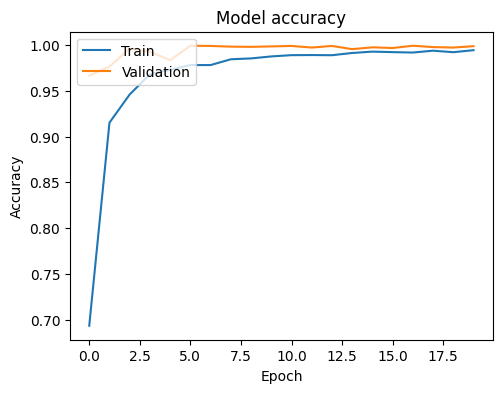

In [42]:
# Plot training history
plt.figure(figsize=(12, 4))

# Plot training & validation accuracy values
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(['Train', 'Validation'], loc='upper left')

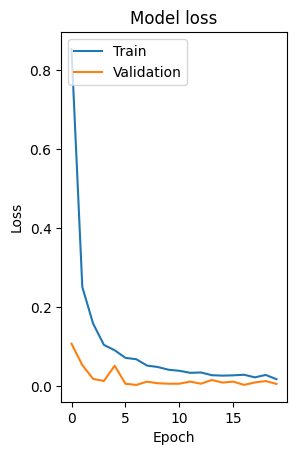

In [43]:
# Plot training & validation loss values
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(['Train', 'Validation'], loc='upper left')

plt.show()

# Evaluate the model

In [45]:
test_loss, test_accuracy = model.evaluate(X_test, y_test)
print(f'Test accuracy: {test_accuracy:.2f}%')


125/125 [==============================] - 1s 6ms/step - loss: 0.0055 - accuracy: 0.9987
Test accuracy: 1.00%


# Confusion Matrix

125/125 [==============================] - 1s 4ms/step


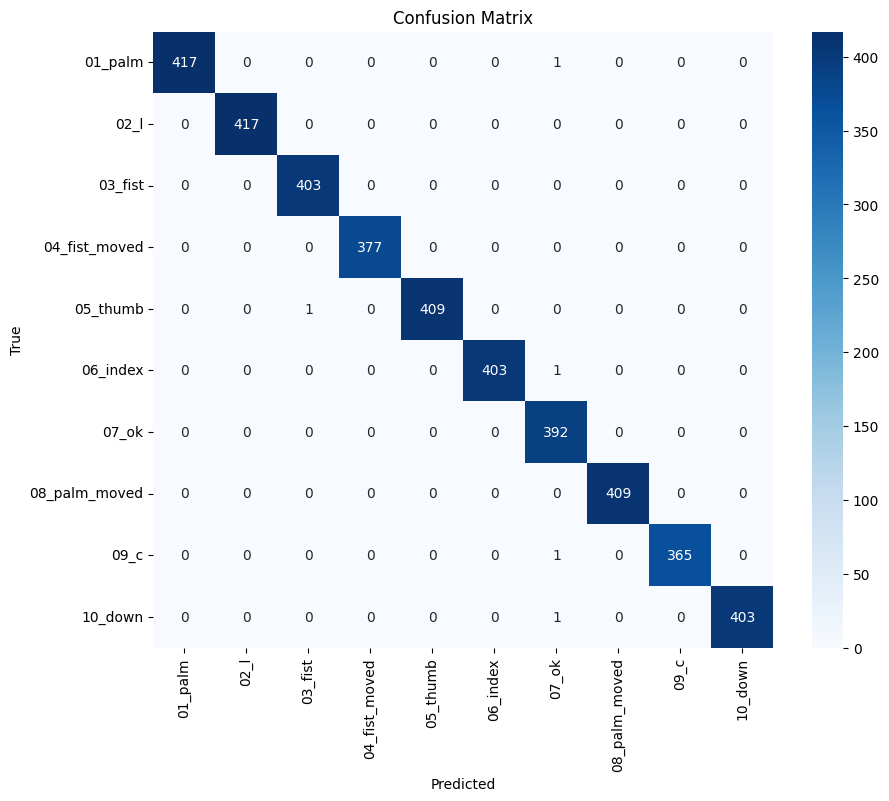

In [46]:
y_pred = model.predict(X_test)
y_pred_classes = np.argmax(y_pred, axis=1)
y_true = np.argmax(y_test, axis=1)

conf_matrix = confusion_matrix(y_true, y_pred_classes)
plt.figure(figsize=(10, 8))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=label_names, yticklabels=label_names)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

# Classification Report

In [47]:
print("Classification Report:\n")
print(classification_report(y_true, y_pred_classes, target_names=label_names))

Classification Report:

               precision    recall  f1-score   support

      01_palm       1.00      1.00      1.00       418
         02_l       1.00      1.00      1.00       417
      03_fist       1.00      1.00      1.00       403
04_fist_moved       1.00      1.00      1.00       377
     05_thumb       1.00      1.00      1.00       410
     06_index       1.00      1.00      1.00       404
        07_ok       0.99      1.00      0.99       392
08_palm_moved       1.00      1.00      1.00       409
         09_c       1.00      1.00      1.00       366
      10_down       1.00      1.00      1.00       404

     accuracy                           1.00      4000
    macro avg       1.00      1.00      1.00      4000
 weighted avg       1.00      1.00      1.00      4000



# Save the model

In [48]:
model.save('hand_gesture_recognition_model.h5')

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(
